In [197]:
#!pip install xgboost

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None

In [3]:
HOME = Path().resolve().parent.parent
data_dir = str(HOME) + '/data/processed/'

In [4]:
listings = pd.read_csv(data_dir + 'listings_transformed.csv.gz')
listings.shape

(458795, 25)

In [20]:
listings.head()

,availability_60,CasosCovMesAnt,neighbourhood_group_cleansed,longitude,beds,id,bedrooms,accommodates,room_type,number_of_reviews,CasosCovMes,file_date,price,availability_90,amenities,latitude,availability_30,availability_365,review_scores_rating,bathrooms,reviews_per_month,property_type,month,year,is_high_season
0,0,0.0,Sant Martí,2.185545,4,18666,2,6,Entire home/apt,1,0.0,1901,130.0,0,18,41.408886,0,6,80.0,1,0.03,Apartment,1,2019,0
1,27,0.0,Eixample,2.173058,6,18674,3,8,Entire home/apt,5,0.0,1901,60.0,55,22,41.404197,12,326,85.0,2,0.07,Apartment,1,2019,0
2,23,0.0,Horta-Guinardó,2.170701,2,31377,1,2,Private room,4,0.0,1901,42.0,30,26,41.410969,14,184,95.0,1,0.09,Apartment,1,2019,0
3,38,0.0,Horta-Guinardó,2.170819,2,31380,1,3,Private room,39,0.0,1901,53.0,47,26,41.410900,24,204,87.0,1,0.90,Apartment,1,2019,0
4,52,0.0,Gràcia,2.159376,1,31958,1,4,Entire home/apt,151,0.0,1901,60.0,80,10,41.409498,25,342,91.0,1,1.57,Apartment,1,2019,0


### 1. Preparing the dataset to make predictions

In [12]:
useful_features = ['year', 'month', 'CasosCovMes', 'CasosCovMesAnt', 'beds', 'bedrooms', 
                   'number_of_reviews', 'amenities', 'room_type',  'bathrooms', 'price',
                   'reviews_per_month', 'accommodates', 'review_scores_rating', 'neighbourhood_group_cleansed', 
                  'is_high_season', 'availability_30', 'availability_60']

In [13]:
df = listings[useful_features].groupby(['year', 'month'], as_index=False).mean()

timeline = df['year']*12 + df['month']
df.insert(2, 'monthly_timeline', timeline)

### 3. Preprocessing data

In [14]:
# This step takes some minutes to finish.

df.loc['av60_lag1'] = df['availability_60'].shift(1)
df.loc['av60_lag2'] = df['availability_60'].shift(2)

In [15]:
df2 = df.dropna().copy()

In [16]:
df2.shape

(28, 17)

In [17]:
df2.head()

,year,month,monthly_timeline,CasosCovMes,CasosCovMesAnt,beds,bedrooms,number_of_reviews,amenities,bathrooms,price,reviews_per_month,accommodates,review_scores_rating,is_high_season,availability_30,availability_60
0,2019.0,1.0,24229.0,0.0,0.0,2.434954,1.637765,34.863304,21.906495,1.293920,92.591465,1.447677,3.583306,78.311662,0.0,15.840251,33.980185
1,2019.0,2.0,24230.0,0.0,0.0,2.456469,1.653713,35.381817,22.069688,1.300764,95.006335,1.435990,3.608517,78.526843,0.0,12.647508,30.142773
2,2019.0,3.0,24231.0,0.0,0.0,2.464269,1.657715,35.531504,22.217049,1.303466,98.562000,1.457684,3.629690,78.965440,0.0,11.557383,26.046817
3,2019.0,4.0,24232.0,0.0,0.0,2.480850,1.669456,36.205600,22.274606,1.306212,98.516575,1.501510,3.638622,79.404409,0.0,8.427229,21.671065
4,2019.0,5.0,24233.0,0.0,0.0,2.445296,1.651363,36.421555,22.202110,1.305929,100.398694,1.539694,3.601746,78.641314,0.0,8.696772,21.082841


### 2. Split train and test set

In [18]:
train = df2[df2['monthly_timeline'] <= 24255].copy()
test = df2[df2['monthly_timeline'] > 24255].copy()

In [19]:
X_train, y_train = train.drop('availability_60', axis=1), train['availability_60']
X_test, y_test = test.drop('availability_60', axis=1), test['availability_60']

### 3. Standardization and Normalization

In [20]:
transformer = RobustScaler()
X_train_norm = transformer.fit_transform(X_train)
X_test_norm = transformer.transform(X_test)

### 4. Train XGBoost model

In [21]:
xgb_model = xgb.XGBRegressor()

In [22]:
xgb_model.fit(X_train_norm, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 5. Predict and validate results

In [23]:
# Predict

train_pred = xgb_model.predict(X_train_norm)
test_pred = xgb_model.predict(X_test_norm)

In [24]:
# Compute RMSE

train_rmse = mean_squared_error(y_train, train_pred)
test_rmse = mean_squared_error(y_test, test_pred)

In [25]:
print(f'The Train RMSE is {train_rmse:.2f}\nThe Test RMSE is {test_rmse:.2f}')

The Train RMSE is 0.00
The Test RMSE is 3.69


### 6. Variable importance for the model

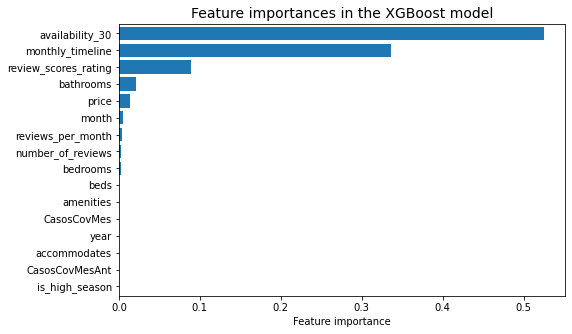

In [26]:
# Producing a dataframe of feature importances
features_weights = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
features_weights.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,5))
plt.barh(features_weights.index, features_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()